# 3D Wind Retrievals

In [1]:
%env ARTS_INCLUDE_PATH=/home/simon/src/arts_clean/controlfiles/
%env ARTS_DATA_PATH=/home/simon/src/arts_xml/
%env ARTS_BUILD_PATH=/home/simon/build/arts_production/arts

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from typhon.arts.workspace import Workspace

env: ARTS_INCLUDE_PATH=/home/simon/src/arts_clean/controlfiles/
env: ARTS_DATA_PATH=/home/simon/src/arts_xml/
env: ARTS_BUILD_PATH=/home/simon/build/arts_production/arts
Loading ARTS API from: /home/simon/build/arts_production/arts/src/arts_api.so


This notebook is essentially a transcript of the `qpack_wind3d_demo.m` script which uses a
three-dimensional atmosphere to retrieve wind speeds.

In [35]:
ws = Workspace()

ws.execute_controlfile("general/general.arts")
ws.execute_controlfile("general/agendas.arts")
ws.execute_controlfile("general/continua.arts")
ws.execute_controlfile("general/planet_earth.arts")

ws.Copy(ws.abs_xsec_agenda,   ws.abs_xsec_agenda__noCIA)
ws.Copy(ws.ppath_agenda,      ws.ppath_agenda__FollowSensorLosPath)
ws.Copy(ws.ppath_step_agenda, ws.ppath_step_agenda__GeometricPath)
ws.Copy(ws.iy_space_agenda,   ws.iy_space_agenda__CosmicBackground)
ws.Copy(ws.iy_surface_agenda, ws.iy_surface_agenda__UseSurfaceRtprop)
ws.Copy(ws.iy_main_agenda,    ws.iy_main_agenda__Emission)
ws.Copy(ws.propmat_clearsky_agenda, ws.propmat_clearsky_agenda__OnTheFly)


general/general.arts
dict_keys(['general/general.arts', 'general/agendas.arts', 'general/continua.arts', 'general/planet_earth.arts'])
general/agendas.arts
dict_keys(['general/general.arts', 'general/agendas.arts', 'general/continua.arts', 'general/planet_earth.arts'])
general/continua.arts
dict_keys(['general/general.arts', 'general/agendas.arts', 'general/continua.arts', 'general/planet_earth.arts'])
general/planet_earth.arts
dict_keys(['general/general.arts', 'general/agendas.arts', 'general/continua.arts', 'general/planet_earth.arts'])


## General Settings

For the wind retrievals, the forward model calculations are performed on a 3D atmosphere grid.
Radiation is assumed to be unpolarized.

In [36]:
ws.atmosphere_dim = 3
ws.stokes_dim     = 1
ws.iy_unit = "RJBT"

## Absorption

We only consider absorption from ozone in this example. The lineshape data is available from
the ARTS testdata available in `controlfiles/testdata`.

In [37]:
ws.abs_speciesSet(["O3"])
ws.abs_lineshapeDefine("Voigt_Kuntz6", "VVH", 750e9)
ws.ReadXML(ws.abs_lines, "testdata/ozone_line.xml")
ws.abs_lines_per_speciesCreateFromLines()

## Atmosphere (A Priori)

We create a pressure grid using the `PFromZSimple` function to create a grid of approximate pressure levels corresponding to altitudes in the range

$$
z = 0.0, 2000.0, \dots, 94000.0
$$

In [38]:
z_toa  = 95e3;
z_surf = 1e3;
ws.PFromZSimple(ws.p_grid, np.arange(z_surf - 1e3, z_toa, 2e3))
ws.lat_grid = np.arange(-40.0, 10.0, 10.0)
ws.lon_grid = np.arange(30.0, 80.0, 10.0)
ws.z_surface = z_surf * np.ones((np.asarray(ws.lat_grid).size,
                                 np.asarray(ws.lon_grid).size))

For the a priori state we read data from the Fascod climatology that is part of the ARTS xml data.

In [39]:
ws.AtmRawRead(basename = "planets/Earth/Fascod/tropical/tropical")
ws.AtmFieldsCalcExpand1D()

## Frequency Grid and Sensor

The frequency grid for the simulation consists of 119 grid
points between 110.516 and 111.156 GHz. The frequencies
are given by a degree-10 polynomial that has been obtained from a fit to the data from the original `qpack` example. This is obscure but also kind of cool.

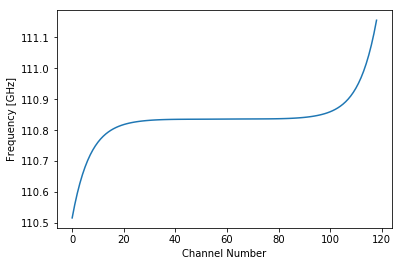

In [40]:
coeffs = np.array([5.06312189e-08, -2.68851772e-05, 6.20655463e-03,
                   -8.16344090e-01,   6.75337174e+01,  -3.66786505e+03,
                   1.32578167e+05,  -3.14514304e+06,   4.57491354e+07,
                   1.10516484e+11])
ws.f_grid = np.poly1d(coeffs)(np.arange(119))

plt.plot(ws.f_grid.value() * 1e-9)
plt.xlabel("Channel Number")
plt.ylabel("Frequency [GHz]")



For the sensor we assume a channel width and channel spacing of 50 kHz. We also call `AntennaOff` to compute
only one pencilbeam along the line of sight of the sensor.

In [41]:
df = 50e3
f_backend = np.arange(ws.f_grid.value().min() + 2.0 * df, ws.f_grid.value().max() - 2.0 * df, df)
ws.backend_channel_responseGaussian(np.array([df]), np.array([2.0]))
ws.AntennaOff()

ws.sensor_norm = 1
ws.sensor_responseInit()

### Sensor Position and Viewing Geometry

5 Measurements are performed, one straight up, and four with zenith angle $70^\circ$ in directions SW, NW, NE, SE. In ARTS the measurement directions are given by a two-column matrix, where the first column contains the zenith angle and the second column the azimuth angle.

In [42]:
ws.sensor_los = np.array([[0.0, 0.0,],
                          [70.0, -135.0],
                          [70.0, -45.0],
                          [70.0, 45.0],
                          [70.0, 135.0]])
ws.sensor_pos = np.array([[2000.0, -21.1, 55.6]] * 5)

## Reference Measurement

Before we can calculate `y`, our setup needs to pass the following tests:

In [47]:
ws.jacobianOff()
ws.propmat_clearsky_agenda_checkedCalc()
ws.sensor_checkedCalc()
ws.atmgeom_checkedCalc()
ws.atmfields_checkedCalc()
ws.abs_xsec_agenda_checkedCalc()
ws.cloudboxOff()
ws.cloudbox_checkedCalc()

Now, we can run the simulation using the `yCalc` WSM and display the results. The results for all 5 measurements are stacked in `ws.y`.

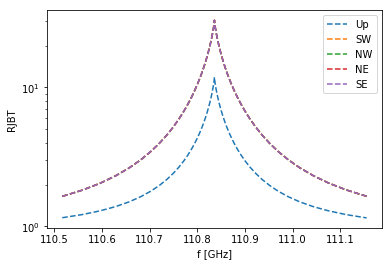

In [59]:
ws.yCalc()

# Plot results
y = np.asarray(ws.y)
f = np.asarray(ws.f_grid)
labels = ["Up", "SW", "NW", "NE", "SE"]
for i,l in zip(range(0, y.size, y.size // 5), labels):
    plt.plot(f * 1e-9, y[i:i+f.size], label=l)
plt.xlabel("f [GHz]")
plt.ylabel("RJBT")
plt.legend()